### Importing Libraries
The first step in any Python script or Jupyter notebook is to import the necessary libraries. Here, we are importing libraries that will be used for stock data retrieval, risk portfolio analysis, time management, threading, and backtesting with the Zipline Reloaded framework.

In [1]:
import pandas as pd
import numpy as np

from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    symbol,
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    get_datetime,
    set_commission,
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    schedule_function,
    set_commission,
    set_slippage,
    set_benchmark
)
from zipline.finance import commission, slippage
import pyfolio as pf

### Trade settings
Instead of hard coding these settings inside the backtest, we'll make it easier on ourselves by setting them up front. In this case,set the number of long and short positions to take in our portfolio and the average dollar volume screener.

In [2]:
N_LONGS = N_SHORTS = 50
DOLLAR_VOLUME = 500

### The custom momentum factor
The class inherits from CustomFactor and specifies its inputs and the window length required for its computations. The inputs include the closing price of US equities (USEquityPricing.close) and the returns over a specified window length (126 trading days in this case). The window_length attribute is set to 252, which typically represents the number of trading days in a year. The compute method is where the core logic of the factor is implemented. This method is automatically called by Zipline with the necessary data aligned according to the specified inputs and window_length. The compute method calculates the momentum factor for each asset based on price changes over different periods: the change in price over the last 252 days (1 year) and the change over the last 21 days (1 month). This is then normalized by the standard deviation of returns over the specified period, to account for volatility. This normalization provides a relative measure of momentum, making it more comparable across different assets.

In [119]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

### Create the Pipeline
A Pipeline is a framework that allows for the definition and efficient computation of a wide array of financial data over a set of assets. Within this pipeline, it incorporates a custom factor, MomentumFactor(), and a built-in factor, AverageDollarVolume(window_length=30). The pipeline is set up with four columns: "factor" holds the computed momentum values, "longs" and "shorts" represent the top and bottom assets based on momentum for a specified number of assets (N_LONGS and N_SHORTS), and "ranking" provides a rank of assets based on their momentum. We then use the built in AverageDollarVolume factor to set a screener to only include the top 500 assets by dollar volume.

In [121]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=21)
    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(N_LONGS),
            "shorts": momentum.bottom(N_SHORTS),
            "ranking": momentum.rank(),
        },
        screen=dollar_volume.top(DOLLAR_VOLUME),
    )

### Recalculate the momentum factor
This function will be called before the trading day starts. It recalculate the factor values for each asset in the universe.

In [122]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

### Initialize the backtest
The initialize function is run at the inception of the backtest. This is where we set up variables and execute calculations we want to use throughout the backtest. The context object is used to store state throughout the backtest. Here, we attach, or install, the Pipeline for use in the backtest. Then we schedule the rebalance function defined next to run at the market open every week on Monday. Finally, we set a commission and slippage model.

In [123]:
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    
    # Set up the commission model to charge us per share and a volume slippage model
    set_commission(
        us_equities=commission.PerShare(
            cost=0.005,
            min_trade_cost=2.0
        )
    )
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(
            volume_limit=0.0025, 
            price_impact=0.01
        )
    )
    set_benchmark(symbol("SPY"))

### Set our rebalance logic
In the initialize function, we scheduled the rebalance function to run. This is where the trade logic lives. First, we get DataFrame containing the factor data set in the before_trading_start function. We get the list of selected assets to trade the determine which assets to go long, which to go short, and which to divest. Then we run the exec_trades function on each list passing in the appropriate weights.

In [124]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    
    print(
        f"{get_datetime().date()} Longs: {len(longs)} Shorts: {len(shorts)} Value:{context.portfolio.portfolio_value}"
    )

    exec_trades(
        data, 
        assets=divest, 
        target_percent=0
    )
    exec_trades(
        data, 
        assets=longs, 
        target_percent=1 / N_LONGS
    )
    exec_trades(
        data, 
        assets=shorts, 
        target_percent=-1 / N_SHORTS
    )

### Execute the trades
We loop through every asset, determine if it's tradeable and there are no open orders. Then we order the target percent and Zipline rebalances our portfolio for us.

In [125]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

### Analyze the results
We can ask Zipline to run a function at the conclusion of the backtest. In this case, we simply print the equity curve.

In [126]:
def analyze(context, perf):
    perf.portfolio_value.plot()

### Run the backtest
The run_algorithm funtion kicks off the backtest. It takes the start and end date, the initialize function that runs at the inception of the backtest, the analyze function that runs at the conclusion of the backtest, the capital to start the backtest with, and the name of the bundle.

In [127]:
perf = run_algorithm(
    start=pd.Timestamp("2020-01-01"),
    end=pd.Timestamp("2022-12-31"),
    initialize=initialize,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quotemedia",
)

2020-01-06 Longs: 3 Shorts: 0 Value:100000.0
2020-01-13 Longs: 3 Shorts: 0 Value:100050.91999998913
2020-01-21 Longs: 2 Shorts: 0 Value:100109.66999998144
2020-01-27 Longs: 3 Shorts: 0 Value:100146.3399999751
2020-02-03 Longs: 2 Shorts: 0 Value:100188.3199999722
2020-02-10 Longs: 1 Shorts: 0 Value:100149.69999995836
2020-02-18 Longs: 2 Shorts: 2 Value:100177.93999995531
2020-02-24 Longs: 3 Shorts: 2 Value:100079.3299999492
2020-03-02 Longs: 8 Shorts: 4 Value:100015.60999994753
2020-03-09 Longs: 6 Shorts: 6 Value:95417.45999994516
2020-03-16 Longs: 5 Shorts: 9 Value:87276.29999994115
2020-03-23 Longs: 4 Shorts: 11 Value:87345.8699999395
2020-03-30 Longs: 3 Shorts: 0 Value:93184.88999993422
2020-04-06 Longs: 5 Shorts: 0 Value:93135.85999992903
2020-04-13 Longs: 5 Shorts: 0 Value:93121.15999992538
2020-04-20 Longs: 4 Shorts: 0 Value:93314.51499991502
2020-04-27 Longs: 8 Shorts: 0 Value:93436.81499991474
2020-05-04 Longs: 6 Shorts: 0 Value:93479.10499990694
2020-05-11 Longs: 7 Shorts: 0 Va

2022-11-21 Longs: 2 Shorts: 0 Value:104414.08986755402
2022-11-28 Longs: 2 Shorts: 0 Value:104552.42986755393
2022-12-05 Longs: 2 Shorts: 0 Value:104549.22986755233
2022-12-12 Longs: 2 Shorts: 0 Value:104415.85986755232
2022-12-19 Longs: 3 Shorts: 0 Value:104207.31986755141
2022-12-27 Longs: 2 Shorts: 0 Value:104458.50986754781


In [131]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

Start date,2020-01-02
End date,2022-12-30
Total months,36
,Backtest
Annual return,1.415%
Cumulative returns,4.305%
Annual volatility,9.702%
Sharpe ratio,0.19
Calmar ratio,0.10
Stability,0.41
Max drawdown,-14.189%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.19,2020-03-04,2020-03-20,2020-12-15,205
1,10.00,2021-02-17,2022-01-27,NaT,NaN
2,1.82,2021-02-09,2021-02-10,2021-02-16,6
3,1.44,2020-12-18,2020-12-28,2020-12-30,9
4,1.31,2021-01-21,2021-01-27,2021-02-05,12


Stress Events,mean,min,max
Covid,0.01%,-6.95%,4.12%


Top 10 long positions of all time,max
sid,
RIOT,3.57%
MVIS,2.88%
JMIA,2.87%
MARA,2.86%
TSLA,2.85%
BTBT,2.76%
ARCT,2.71%
GSX,2.69%
BLNK,2.65%


Top 10 short positions of all time,max
sid,
TVIX,-5.42%
UVXY,-4.41%
CEI,-3.54%
ACB,-3.25%
CENN,-2.77%
NAKD,-2.77%
SDOW,-2.75%
BNGO,-2.75%
BYSI,-2.66%


Top 10 positions of all time,max
sid,
TVIX,5.42%
UVXY,4.41%
RIOT,3.57%
CEI,3.54%
ACB,3.25%
MVIS,2.88%
JMIA,2.87%
MARA,2.86%
TSLA,2.85%


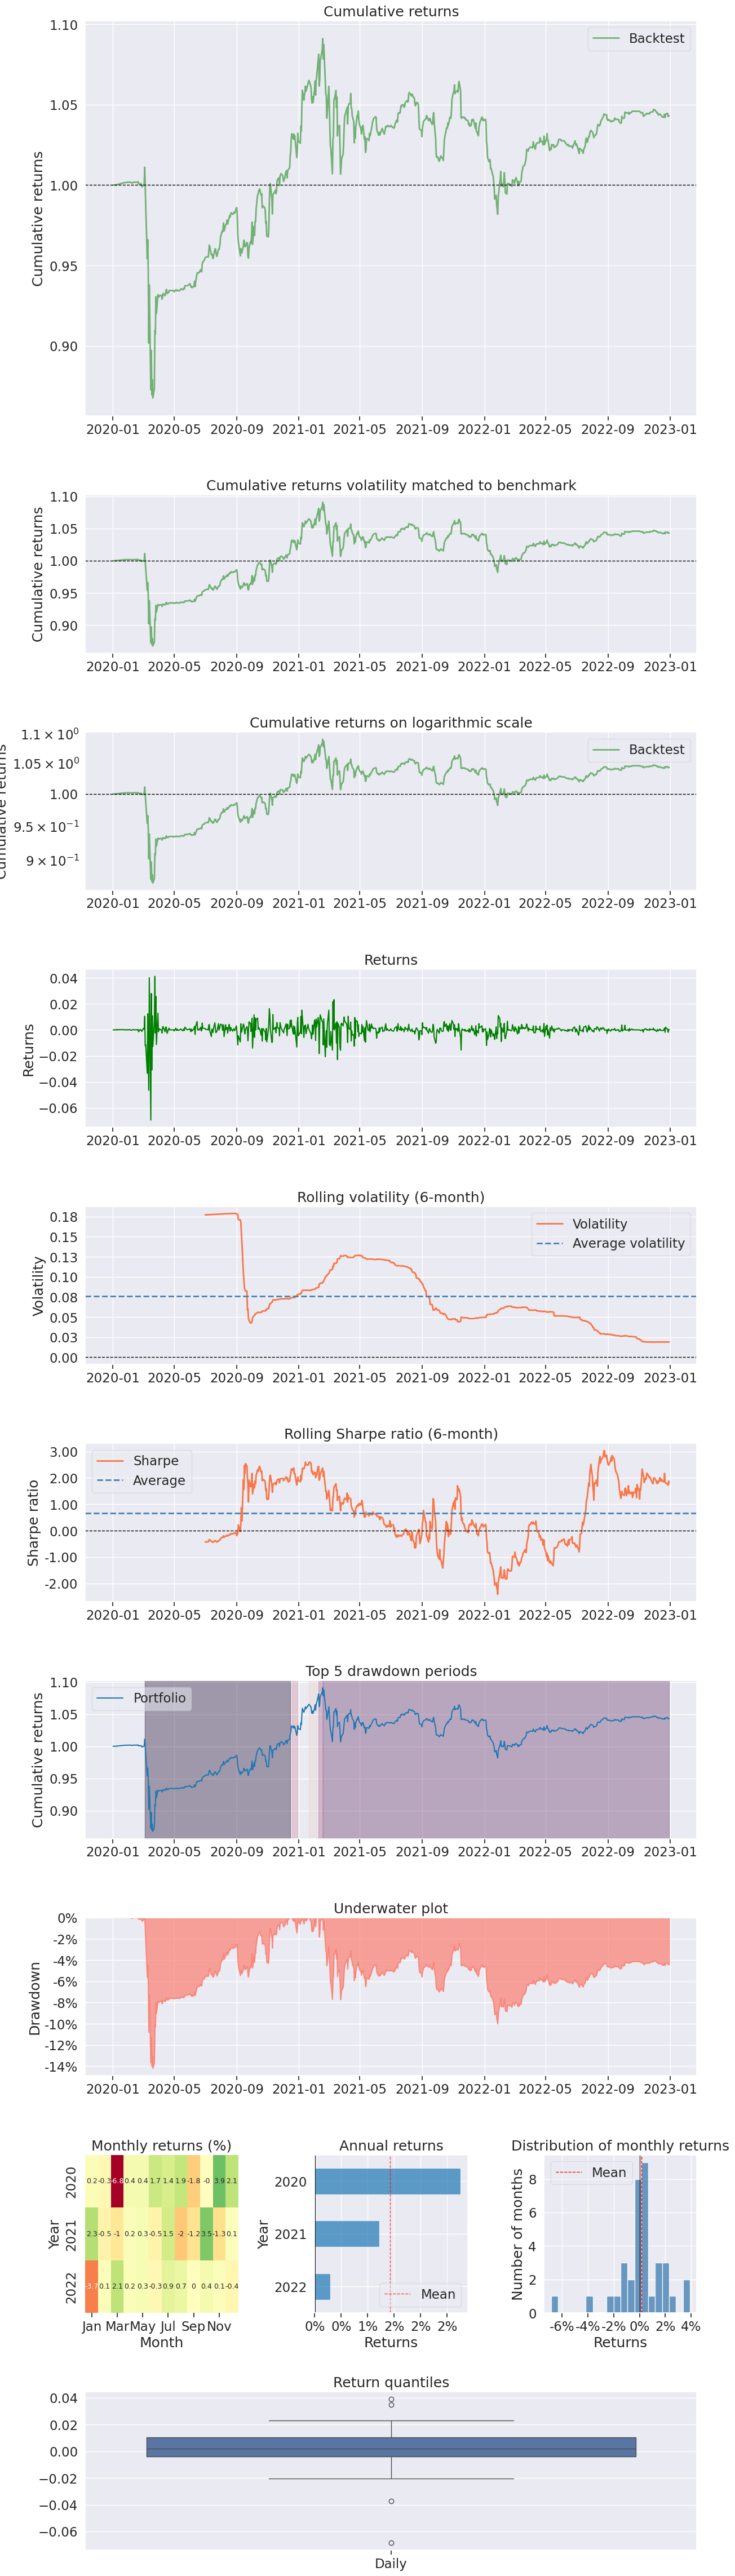

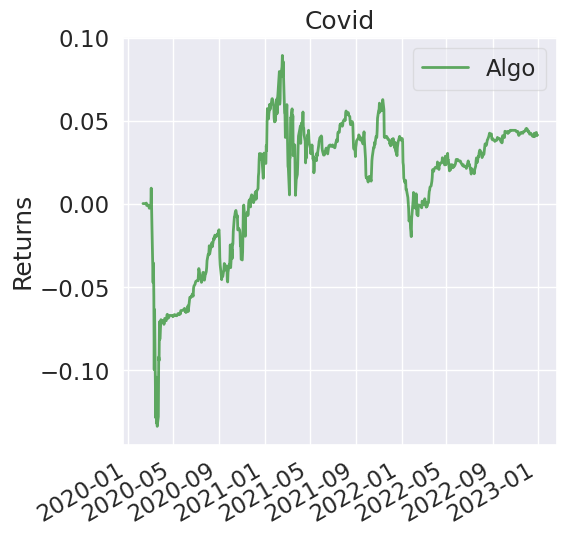

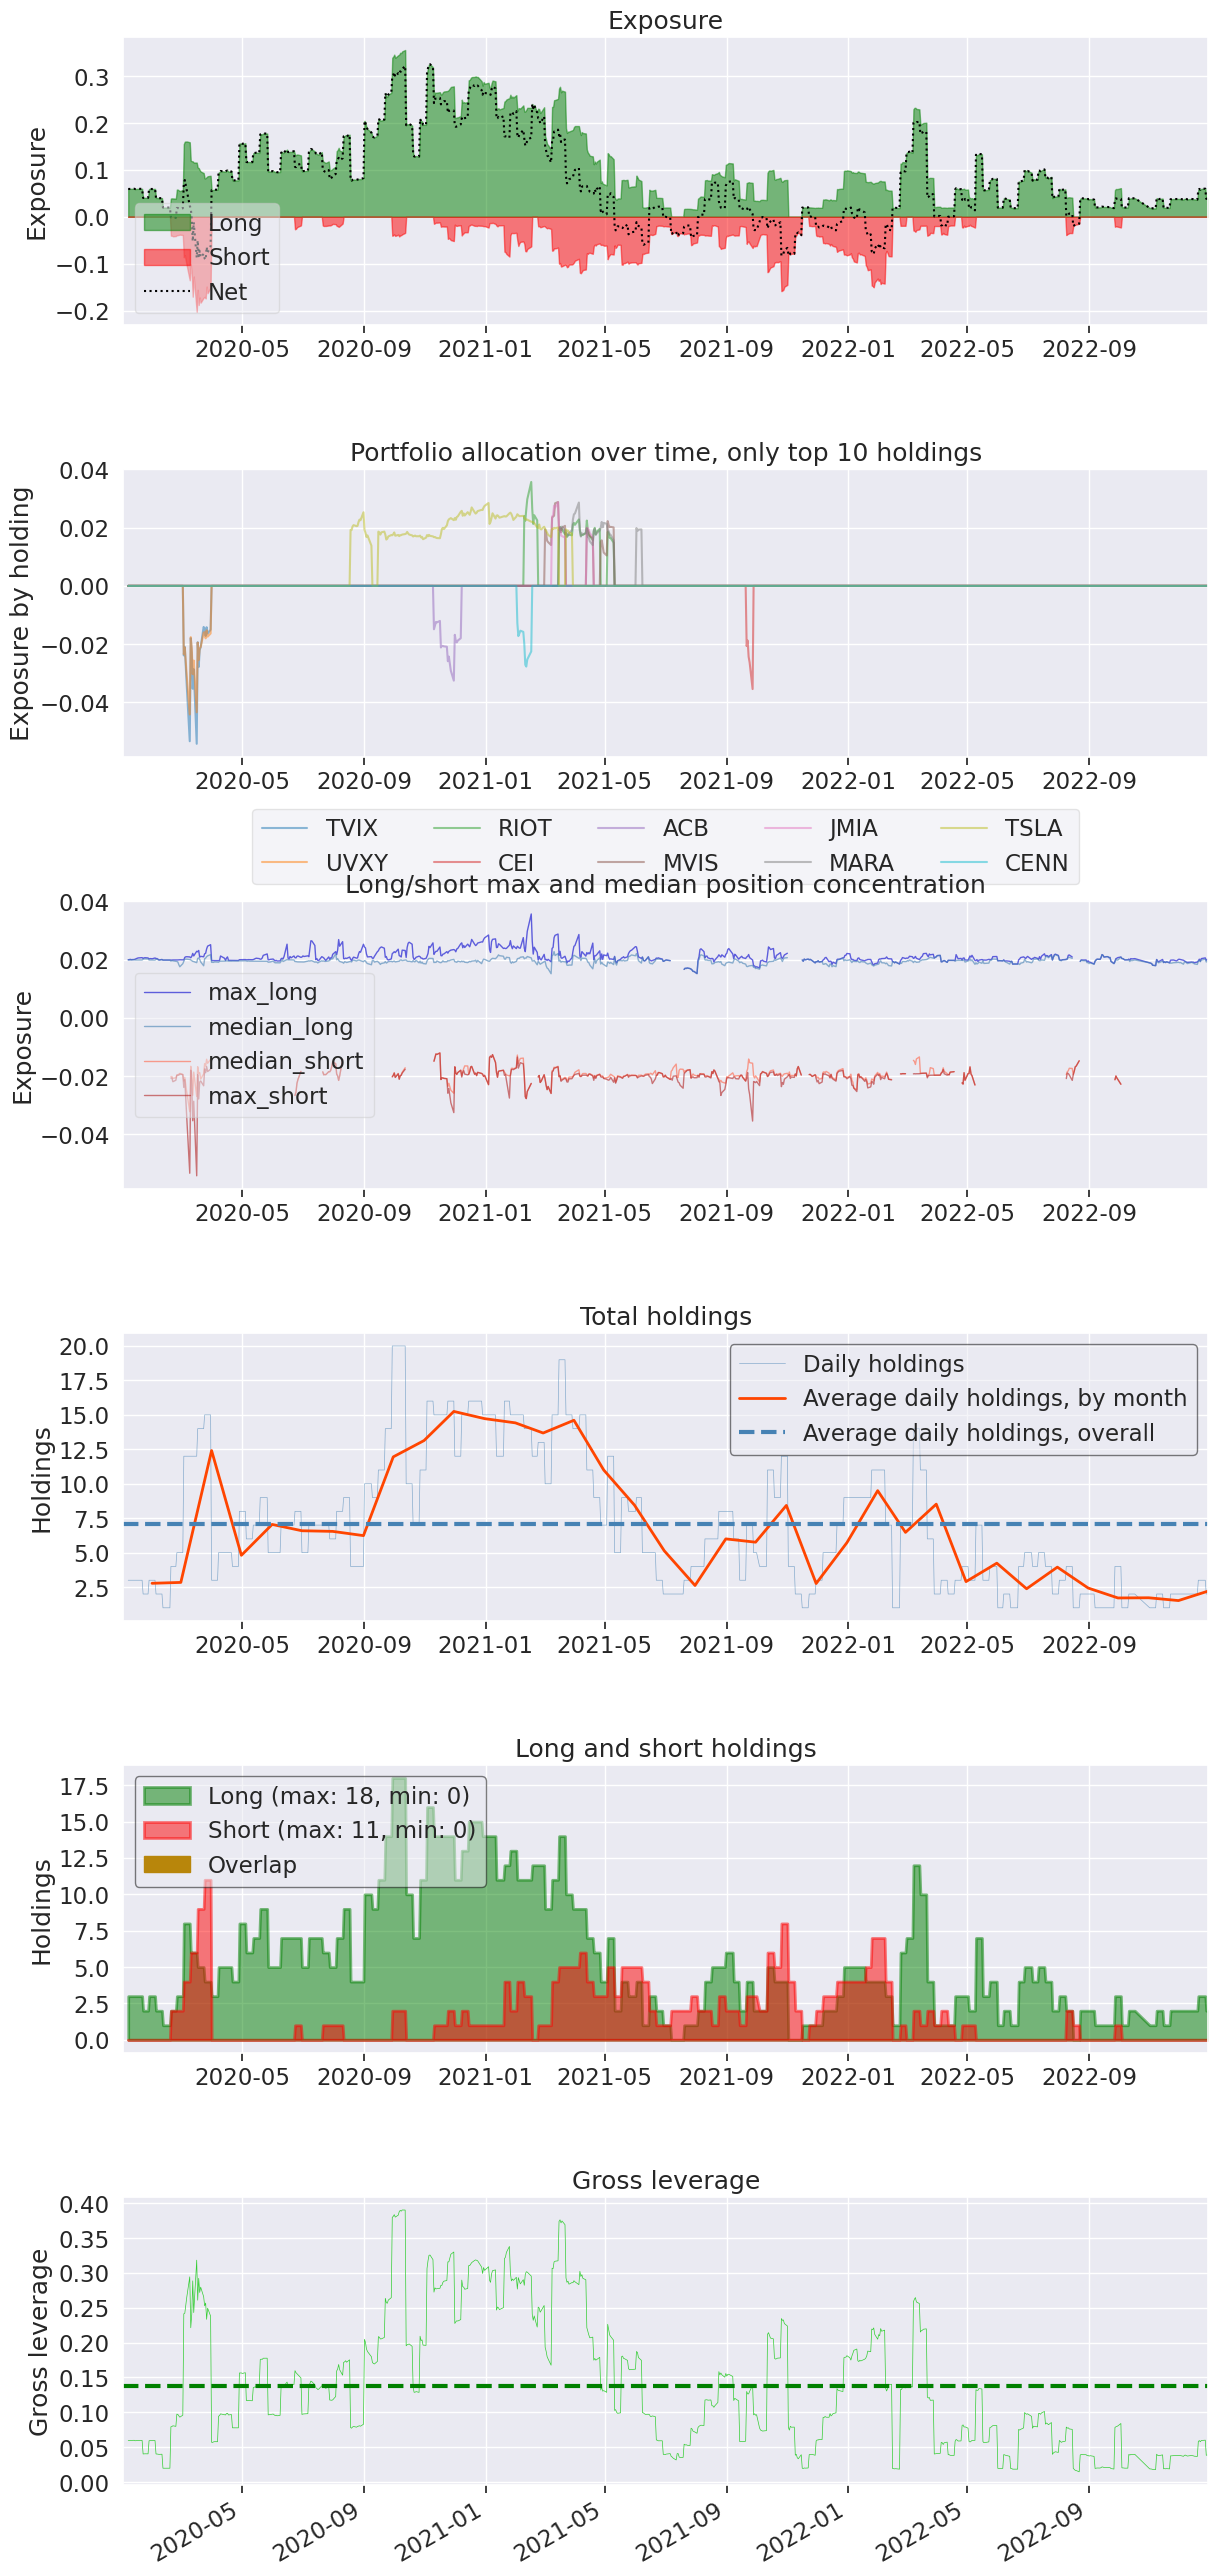

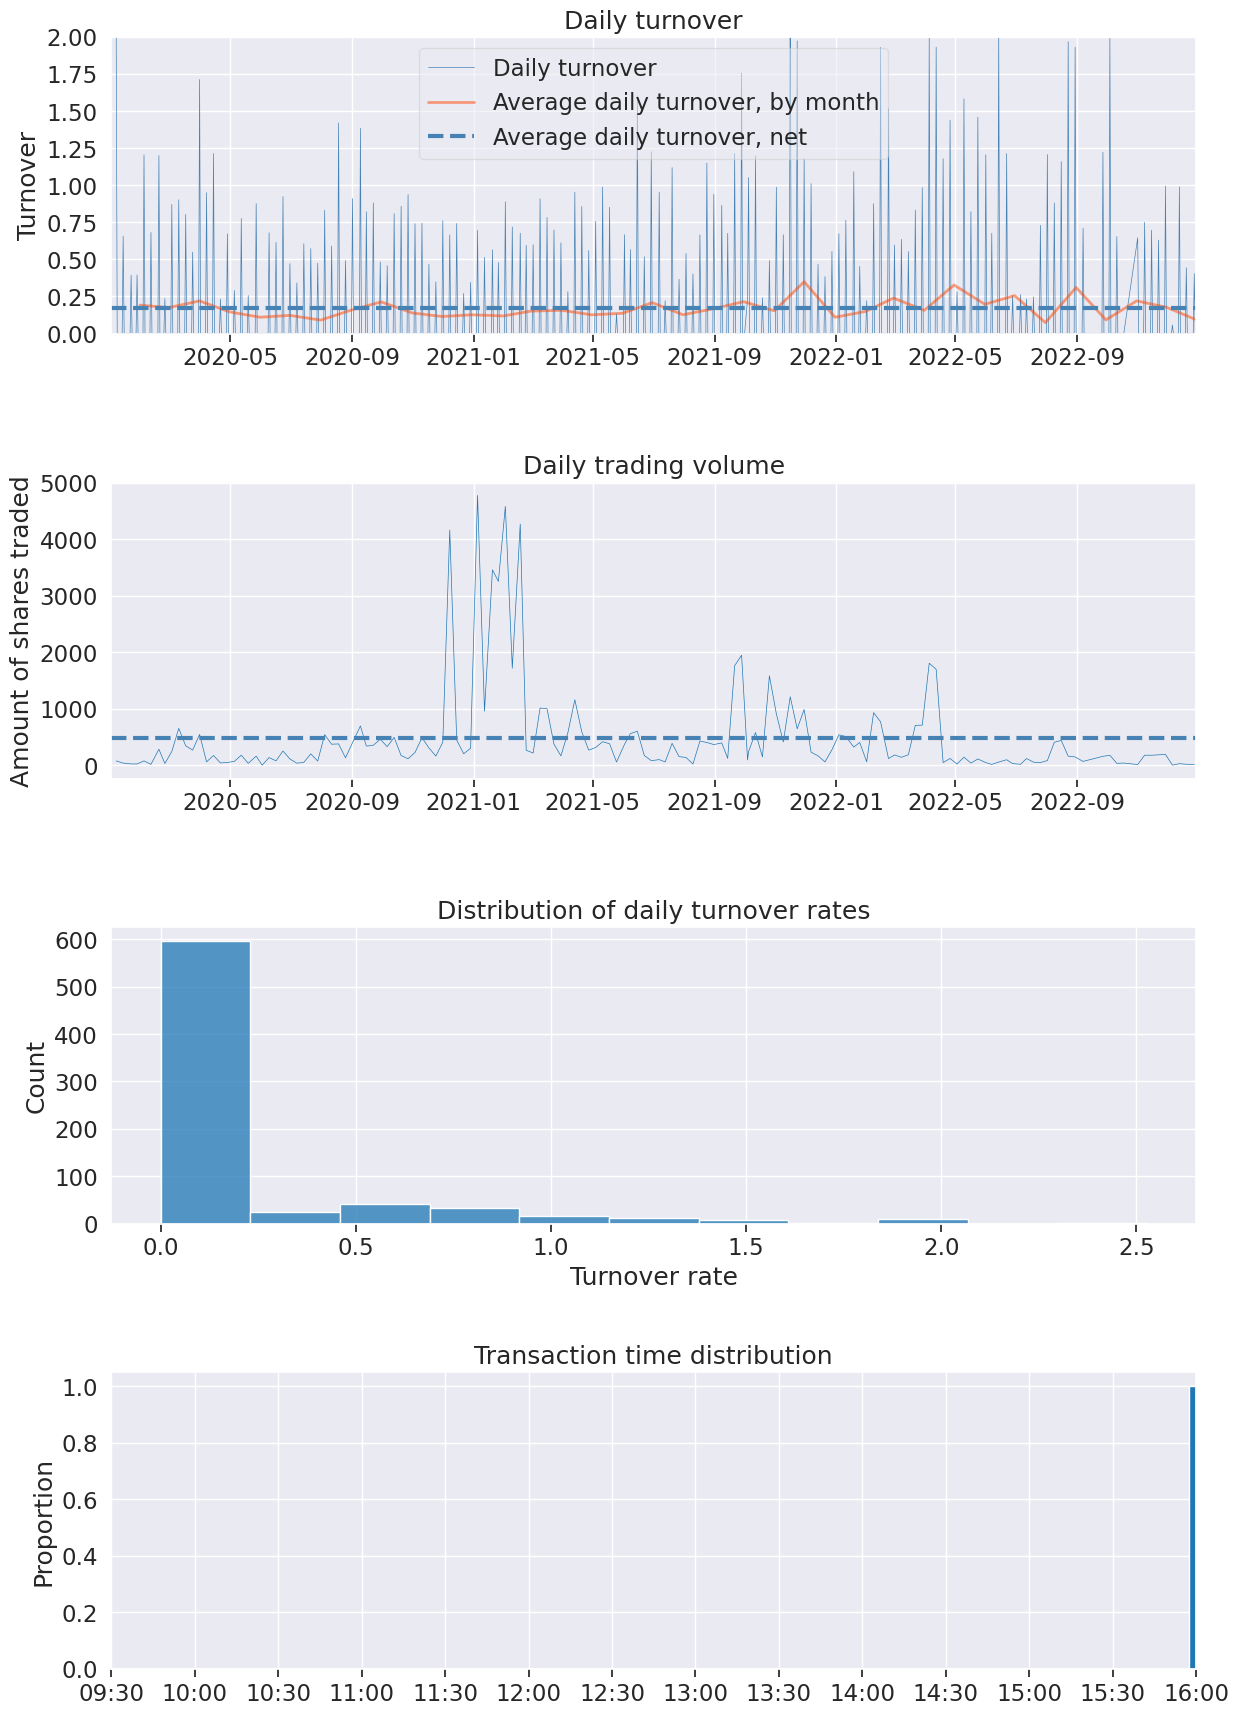

In [132]:
pf.create_full_tear_sheet(returns, positions, transactions)